**Домашняя работа №3**

**Задание**

Представлен датасет центра приюта животных, и вашей задачей будет обучить модель таким образом, чтобы  по определенным признакам была возможность максимально уверенно предсказать метки 'Adoption' и 'Transfer' (столбец “outcome_type”).

1. Проверка наличия/обработка пропусков
2. Проверьте взаимосвязи между признаками
3. Попробуйте создать свои признаки
4. Удалите лишние
5. Обратите внимание на текстовые столбцы. Подумайте, что можно извлечь полезного оттуда
6. Использование профайлера вам поможет.
7. PCA (Метод главных компонент)
8. "Случайный лес" вместо линейного классификатора

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling

from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

In [267]:
data = pd.read_csv('aac_shelter_outcomes.csv')
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [196]:
data.shape

(78256, 12)

In [269]:
data.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,78248,78256,78256,78256,78256,78256,78256,78256,54370,35963,78244,78254
unique,46,70855,5,2128,525,5869,64361,64361,14574,19,9,5
top,1 year,A718223,Dog,Domestic Shorthair Mix,Black/White,2014-05-05T00:00:00,2016-04-18T00:00:00,2016-04-18T00:00:00,Bella,Partner,Adoption,Neutered Male
freq,14355,11,44242,23335,8153,112,39,39,344,19660,33112,27784


In [270]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_outcome  78248 non-null  object
 1   animal_id         78256 non-null  object
 2   animal_type       78256 non-null  object
 3   breed             78256 non-null  object
 4   color             78256 non-null  object
 5   date_of_birth     78256 non-null  object
 6   datetime          78256 non-null  object
 7   monthyear         78256 non-null  object
 8   name              54370 non-null  object
 9   outcome_subtype   35963 non-null  object
 10  outcome_type      78244 non-null  object
 11  sex_upon_outcome  78254 non-null  object
dtypes: object(12)
memory usage: 3.6+ MB


In [199]:
data.outcome_type.value_counts()

Adoption           33112
Transfer           23499
Return to Owner    14354
Euthanasia          6080
Died                 680
Disposal             307
Rto-Adopt            150
Missing               46
Relocate              16
Name: outcome_type, dtype: int64

Оценим зависимости переменных между собой.

Изучим данные профайлера (profile_report)

In [200]:
pandas_profiling.ProfileReport(data)

В столбцах name и outcome_subtype много пропусков, удалим их. Столбцы datetime и monthyear дублируют друг друга - оставим один из них. К тому же анализ выявил дубликаты, их надо удалить

In [271]:
data.drop(['monthyear', 'name', 'outcome_subtype'], axis=1, inplace=True)
data.drop_duplicates().shape
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,Euthanasia,Unknown


Создадим новый признак delta (похоже, это возраст питомца) из date_of_birth	и datetime, и тогда признак age_upon_outcome станет лишним

In [272]:
data['datetime'] = pd.to_datetime(data['datetime'])
data['date_of_birth'] = pd.to_datetime(data['date_of_birth'])

In [203]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   age_upon_outcome  78248 non-null  object        
 1   animal_id         78256 non-null  object        
 2   animal_type       78256 non-null  object        
 3   breed             78256 non-null  object        
 4   color             78256 non-null  object        
 5   date_of_birth     78256 non-null  datetime64[ns]
 6   datetime          78256 non-null  datetime64[ns]
 7   outcome_type      78244 non-null  object        
 8   sex_upon_outcome  78254 non-null  object        
dtypes: datetime64[ns](2), object(7)
memory usage: 3.3+ MB


In [273]:
import datetime
from datetime import timedelta, datetime
data['delta'] = data['datetime'] - data['date_of_birth']
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,outcome_type,sex_upon_outcome,delta
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,Transfer,Intact Male,15 days 16:04:00
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,Transfer,Spayed Female,366 days 11:47:00
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,Adoption,Neutered Male,429 days 14:20:00
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,Transfer,Neutered Male,3300 days 15:50:00
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,Euthanasia,Unknown,181 days 14:04:00


In [274]:
data.drop(['datetime', 'date_of_birth', 'age_upon_outcome'], axis=1, inplace=True)
data.head()

,animal_id,animal_type,breed,color,outcome_type,sex_upon_outcome,delta
0,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,Transfer,Intact Male,15 days 16:04:00
1,A666430,Dog,Beagle Mix,White/Brown,Transfer,Spayed Female,366 days 11:47:00
2,A675708,Dog,Pit Bull,Blue/White,Adoption,Neutered Male,429 days 14:20:00
3,A680386,Dog,Miniature Schnauzer Mix,White,Transfer,Neutered Male,3300 days 15:50:00
4,A683115,Other,Bat Mix,Brown,Euthanasia,Unknown,181 days 14:04:00


In [206]:
pandas_profiling.ProfileReport(data)

Из столбца sex_upon_outcome вытащим информацию о поле животного и о том, кастрировано (стерилизовано) оно или нет:

In [275]:
data['sex_upon_outcome'] = data['sex_upon_outcome'].astype(str)

data['sex']= data['sex_upon_outcome']
data['fert']= data['sex_upon_outcome']

data['sex'] = [col.replace('Neutered Male', 'Male') for col in data['sex']]                                                                             
data['sex'] = [col.replace('Intact Male', 'Male') for col in data['sex']]
data['sex'] = [col.replace('Intact Female', 'Female') for col in data['sex']]                                                                               
data['sex'] = [col.replace('Spayed Female', 'Female') for col in data['sex']]

data['fert'] = [col.replace('Neutered Male', 'non-fert') for col in data['fert']]                                                                             
data['fert'] = [col.replace('Intact Male', 'fert') for col in data['fert']]
data['fert'] = [col.replace('Intact Female', 'fert') for col in data['fert']]                                                                               
data['fert'] = [col.replace('Spayed Female', 'non-fert') for col in data['fert']]

data.drop(['sex_upon_outcome'], axis=1, inplace=True)

data.head()

,animal_id,animal_type,breed,color,outcome_type,delta,sex,fert
0,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,Transfer,15 days 16:04:00,Male,fert
1,A666430,Dog,Beagle Mix,White/Brown,Transfer,366 days 11:47:00,Female,non-fert
2,A675708,Dog,Pit Bull,Blue/White,Adoption,429 days 14:20:00,Male,non-fert
3,A680386,Dog,Miniature Schnauzer Mix,White,Transfer,3300 days 15:50:00,Male,non-fert
4,A683115,Other,Bat Mix,Brown,Euthanasia,181 days 14:04:00,Unknown,Unknown


In [208]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   animal_id     78256 non-null  object         
 1   animal_type   78256 non-null  object         
 2   breed         78256 non-null  object         
 3   color         78256 non-null  object         
 4   outcome_type  78244 non-null  object         
 5   delta         78256 non-null  timedelta64[ns]
 6   sex           78256 non-null  object         
 7   fert          78256 non-null  object         
dtypes: object(7), timedelta64[ns](1)
memory usage: 2.7+ MB


Сделаем наши качественные признаки читаемыми для моделей:

In [276]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_enc = LabelEncoder()
oh_enc = OneHotEncoder()                                                                      

In [277]:
data = data.loc[data['animal_type'].isin(['Cat', 'Dog'])]

In [278]:
an_type = oh_enc.fit_transform(data[['animal_type']]).toarray()
an_type = pd.DataFrame(an_type, columns=oh_enc.categories_[0])
an_type.head(5)

,Cat,Dog
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [279]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
data['breed'] = labelencoder.fit_transform(data['breed'])
data['color'] = labelencoder.fit_transform(data['color'])

In [280]:
data = data.dropna()

In [215]:
data = data.loc[data['outcome_type'].isin(['Adoption', 'Transfer'])]

In [216]:
out_type = oh_enc.fit_transform(data[['outcome_type']]).toarray()
out_type = pd.DataFrame(out_type, columns=oh_enc.categories_[0])
out_type.head(5)

,Adoption,Transfer
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,0.0,1.0
4,0.0,1.0


In [217]:
s_out = oh_enc.fit_transform(data[['sex']]).toarray()
s_out = pd.DataFrame(s_out, columns=oh_enc.categories_[0])
s_out.drop(['Unknown'], axis=1, inplace=True)
s_out.head(5)

,Female,Male
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [218]:
f_out = oh_enc.fit_transform(data[['fert']]).toarray()
f_out = pd.DataFrame(f_out, columns=oh_enc.categories_[0])
f_out.head(5)

,Unknown,fert,non-fert
0,0.0,1.0,0.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0


In [219]:
data.drop(['animal_id', 'animal_type', 'outcome_type', 'sex', 'fert'], axis=1, inplace=True)

In [220]:
data['delta'] = data['delta'].astype(str)

Из столбца delta извлечём информацию о возрасте питомца в днях и приведем его к числовому формату, чтобы модели могли "понимать" этот признак:

In [221]:
delta_reg_exp = r'([0-9]+)'
data['days'] = data['delta'].str.extract(delta_reg_exp).values.reshape(-1)

data.drop(['delta'], axis=1, inplace=True)

data['days'] = data['days'].astype(int)

data.head(5)

,breed,color,days
0,897,299,15
1,243,446,366
2,1499,115,429
3,1378,435,3300
5,1267,174,126


Соберем все полученные признаки в один датафрейм:

In [222]:
data = data.join(an_type)
data = data.join(s_out)
data = data.join(f_out)
data = data.join(out_type)

data.head(5)

,breed,color,days,Cat,Dog,Female,Male,Unknown,fert,non-fert,Adoption,Transfer
0,897,299,15,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,243,446,366,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1499,115,429,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,1378,435,3300,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
5,1267,174,126,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [223]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55625 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   breed     55625 non-null  int32  
 1   color     55625 non-null  int32  
 2   days      55625 non-null  int32  
 3   Cat       52356 non-null  float64
 4   Dog       52356 non-null  float64
 5   Female    39402 non-null  float64
 6   Male      39402 non-null  float64
 7   Unknown   39402 non-null  float64
 8   fert      39402 non-null  float64
 9   non-fert  39402 non-null  float64
 10  Adoption  39402 non-null  float64
 11  Transfer  39402 non-null  float64
dtypes: float64(9), int32(3)
memory usage: 6.9 MB


In [224]:
data = data.dropna()

In [225]:
headers = list(data.columns.values)

In [226]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

np_scaled = min_max_scaler.fit_transform(data)
data_norm = pd.DataFrame(np_scaled)
data_norm.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.455099,0.605263,0.002052,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.123288,0.902834,0.050062,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.760528,0.232794,0.058679,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,0.699137,0.880567,0.451375,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.642821,0.352227,0.017234,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [227]:
data_norm.columns = headers
data_norm.head()

,breed,color,days,Cat,Dog,Female,Male,Unknown,fert,non-fert,Adoption,Transfer
0,0.455099,0.605263,0.002052,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.123288,0.902834,0.050062,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.760528,0.232794,0.058679,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,0.699137,0.880567,0.451375,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.642821,0.352227,0.017234,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [228]:
data_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39402 entries, 0 to 39401
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   breed     39402 non-null  float64
 1   color     39402 non-null  float64
 2   days      39402 non-null  float64
 3   Cat       39402 non-null  float64
 4   Dog       39402 non-null  float64
 5   Female    39402 non-null  float64
 6   Male      39402 non-null  float64
 7   Unknown   39402 non-null  float64
 8   fert      39402 non-null  float64
 9   non-fert  39402 non-null  float64
 10  Adoption  39402 non-null  float64
 11  Transfer  39402 non-null  float64
dtypes: float64(12)
memory usage: 3.6 MB


Итак, у нас 2 класса: Adoption и Transfer.
Построим модель **"случйный лес"** (она нам подойдёт, поскольку наши классы несбалансированы)

In [229]:
output_y = data_norm.iloc[:,10:]
input_x = data_norm.iloc[:,:10]

Таргет значение представим в виде наименований классов.

In [230]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
targets=(output_y.iloc[:,:]==1).idxmax(1)
print(targets.value_counts())
Y=le.fit_transform(targets)

Adoption    23162
Transfer    16240
dtype: int64


Выделим из датасета тренировочные и тестовые данные. Тренировочные данные будем использовать для обучения модели. Тестовые данные будем использовать для подсчета качества модели.

In [231]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_x, Y, test_size=0.2)

In [233]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_train,y_train)

RandomForestClassifier()

Наиболее важные атрибуты для модели Random Forest:

No handles with labels found to put in legend.


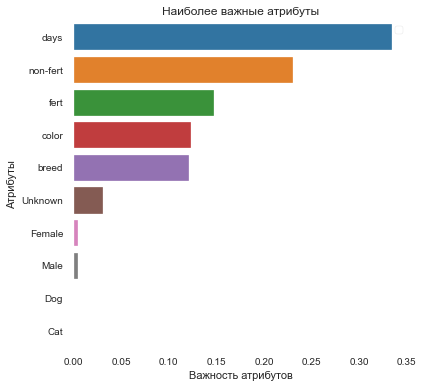

In [234]:
headers = list(X_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

Посчитаем качество модели - classification report:

In [236]:
from sklearn.metrics import classification_report

model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

model.score(X_test, y_test)

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      4623
           1       0.76      0.63      0.69      3258

    accuracy                           0.76      7881
   macro avg       0.76      0.74      0.75      7881
weighted avg       0.76      0.76      0.76      7881



0.763735566552468

Модель "рандомных деревьев" дала точность предсказания порядка 77%

**Вывод:** Наше исследование подтведило тот факт из жизни, что чаще всего люди, когда берут питомца, обращают внимание на возраст и на то, кастрированный (стерилизованный) он или нет.

Применим **PCA**, оставив 5 главных компонентов:

In [264]:
from sklearn.decomposition import PCA

pca_decomp = PCA(n_components=5)
X_pca = pca_decomp.fit_transform(input_x)
X_pca = pd.DataFrame(X_pca)

X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, Y, test_size=0.2)


pca_decomp.fit(X_pca_train,y_pca_train)

X_pca.head(5)

,0,1,2,3,4
0,-0.047919,1.031273,1.119785,0.175064,-0.156133
1,0.266252,-0.833948,-0.433387,0.477962,-0.046274
2,-0.918813,-0.074415,-0.294666,-0.188335,-0.022538
3,-0.920441,-0.074018,-0.294400,0.470530,-0.042893
4,0.267207,-0.832290,-0.432839,-0.067659,-0.025050


In [265]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model2=RandomForestClassifier(n_estimators=100)

# обучаем модель
model2.fit(X_pca_train,y_pca_train)

RandomForestClassifier()

In [266]:
model_pred = model2.predict(X_pca_test)

print(classification_report(y_pca_test, model_pred))

model2.score(X_pca_test, y_pca_test)

              precision    recall  f1-score   support

           0       0.77      0.82      0.79      4611
           1       0.72      0.65      0.68      3270

    accuracy                           0.75      7881
   macro avg       0.74      0.74      0.74      7881
weighted avg       0.75      0.75      0.75      7881



0.7496510595102145

В нашем случае PCA даже немного ухудшил качество предсказания